<a href="https://colab.research.google.com/github/pawara101/notebooks/blob/main/PyTorch/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pyTorch custom dataset Notebook.
* here using own dataset with pytorch.
* to do that we use custom dataset.


## 0. Import PyTorch and setup device agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu121'

In [2]:
## Setup Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cpu


## 1. Get Data
- this dataset is a subset of Food101 dataset.
- our dataset starts with 3 classes of food and only 10% of images(~75% trainning,25% testing)

In [3]:
import requests
import zipfile
from pathlib import Path

## setup a path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"


if image_path.is_dir():
  print(f"{image_path} directory already exists... no need to download")

else:
  print(f"{image_path} does not exists, creating one....")
  image_path.mkdir(parents=True,exist_ok=True)


with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading data....")

  f.write(request.content)

## Unzip file
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  print("Unzipping data....")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exists, creating one....
Unzipping data....


In [4]:
image_path

PosixPath('data/pizza_steak_sushi')

## 2. Becoming one with the data(data preperation and exploaration)

In [5]:
import os

def walk_through_dir(dir_path):

  for dir_path, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dir_path}")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [7]:
## Setup trainning and testing paths
train_dir = image_path / "train"
test_dir = image_path /"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing Image
1. Get all of the Image paths
2. Pick a random image path using `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem()`
4. Open the image using Pyhton PIL
5. show image and print metadata.

Random Image path : data/pizza_steak_sushi/test/pizza/648055.jpg
Image class : pizza
Image height : 512
Image width : 512


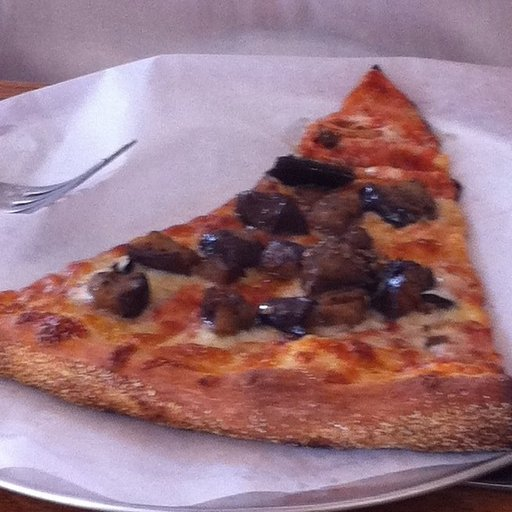

In [8]:
import random
from PIL import Image

#set seed
random.seed(42)

# 1. get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)


# 3. Get image class from path name
image_class = random_image_path.parent.stem


# 4. Open Image
img = Image.open(random_image_path)

# 5. Print Metadata
print(f"Random Image path : {random_image_path}")
print(f"Image class : {image_class}")
print(f'Image height : {img.height}')
print(f'Image width : {img.width}')
img

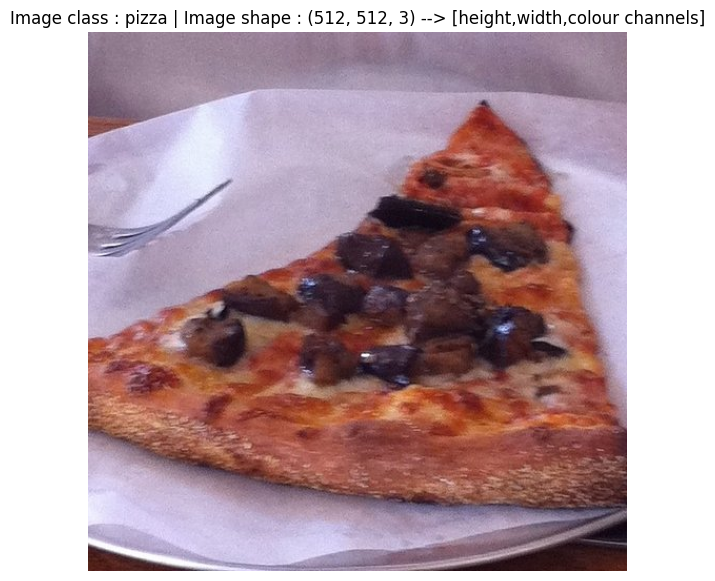

In [9]:
## try to visualise with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn image into an array
img_as_array =np.asarray(img)

# plot with matplot lib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class : {image_class} | Image shape : {img_as_array.shape} --> [height,width,colour channels]")
plt.axis(False)
plt.show()

## 3. Transform data
- Before image data with PyTorch:
    1. Turn target data into tensors.
  

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`


In [11]:
## write a trasnform for image
data_transform = transforms.Compose([
    ## Resize the image
    transforms.Resize(size=(64,64)),
    # Flip the image randomly hrozontally
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn image into a torch.tensor
    transforms.ToTensor()
])

data_transform(img).shape

torch.Size([3, 64, 64])

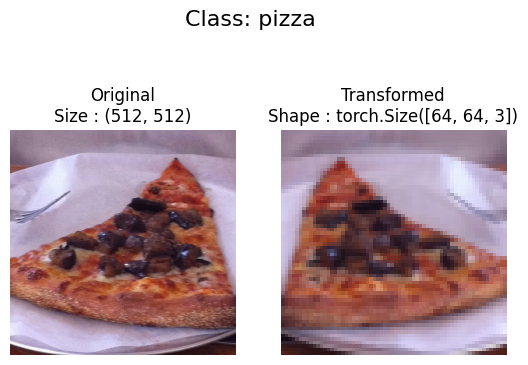

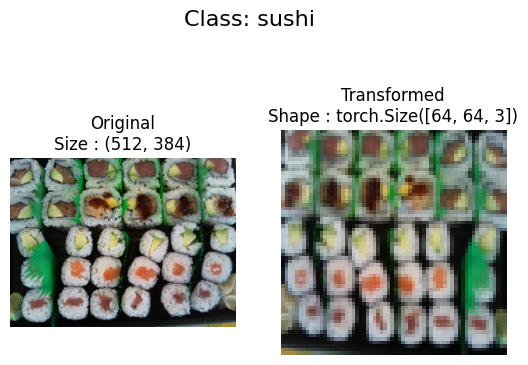

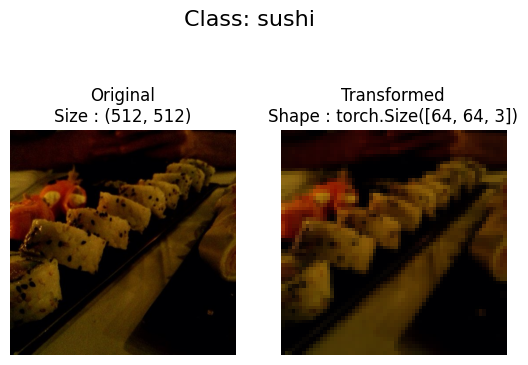

In [12]:
def plot_transformed_images(image_paths,transform,n=3,seed=42):

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize : {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape : {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 01 : Loading Image using `ImageFolder`

In [13]:
## Use Image folder to create dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data  = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
## Get class names as a list.
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
## Get class names as a Dict.
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# check lengths
len(train_data),len(test_data)

(225, 75)

In [17]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [18]:
len(train_data[0])

2

In [19]:
## Index on train_data dataset to get single image and label
img,label = train_data[0][0],train_data[0][1]
print(f"Image Tensor :\n {img}")
print(f"Image shape : {img.shape}")
print(f"Image datatype : {img.dtype}")
print(f"Image Label : {label}")
print(f"Label datatype : {type(label)}")

Image Tensor :
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.

Original shape : torch.Size([3, 64, 64]) => [colour channels,height,width]
Image permute : torch.Size([64, 64, 3]) => [height,width,colour channel]


(-0.5, 63.5, 63.5, -0.5)

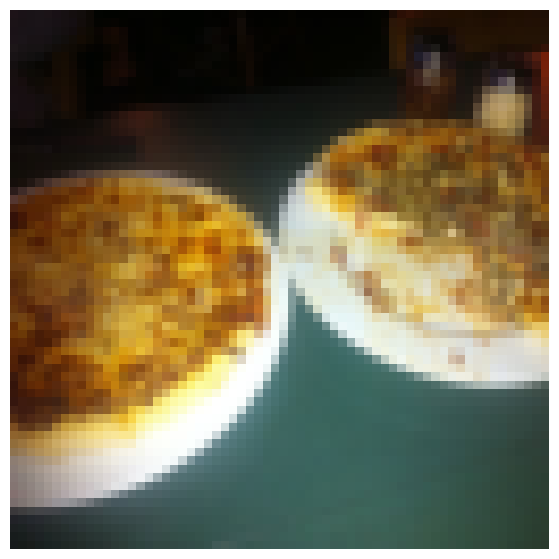

In [20]:
## Reaarange order of dimensions
img_permute = img.permute(1,2,0)

## Print out different shapes
print(f"Original shape : {img.shape} => [colour channels,height,width]")
print(f"Image permute : {img_permute.shape} => [height,width,colour channel]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
# plt.title(class_name[label])

### 4.1 Turn loaded images into `DataLoaders`
* A `DataLoader`

In [21]:
# turn train and test data sets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=True)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d714bb9fd90>,
 <torch.utils.data.dataloader.DataLoader at 0x7d714bb9f7f0>)

In [22]:
len(train_dataloader),len(test_dataloader)

(225, 75)

In [23]:
img,label= next(iter(train_dataloader))

# Batch size will now be 1.
print(f"Image shape : {img.shape} => [batch_size,color_channels,height,width]")
print(f"Label shape : {label.shape}")

Image shape : torch.Size([1, 3, 64, 64]) => [batch_size,color_channels,height,width]
Label shape : torch.Size([1])


## 5. Option 2: Loading Image using a custom dataset.
1. want to be able to load images from file.
2. want to be able to get class names from the dataset.
3. want to be able to get classes as dictionary from Datasets.

pros:
* Can create a `dataset` out of almost anything.
* Not limited to PyTorch pre-built `Datset` functions.

Cons:
* prone to errors and performance issue.

In [24]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

In [25]:
## Instance of torchvision.
train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names.
We want a function to;
- get class names using `os.scandir()`
- Raise an error if class names are not found.
- Turn the class names into a dict.

In [26]:
# setup path for target directory.
target_directory = train_dir
print(f"Target dir : {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir : data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [27]:
def find_classes(directory: str) -> Tuple[List[str],Dict[str,int]]:
  """
  Finds the class folder names in a target directory..
  """

  #1. Get the class names by scanning the target directory.
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  #2. raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Could not find any classes in {directory} ....")

  #3. Create dictionary of index labels
  class_to_idx = {class_name: i for i , class_name in enumerate(classes)}
  return classes, class_to_idx

In [28]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`
To create own cutom dataset
1. Subclass `torch.utils.Dataset`
2. Init our subclass with a target directory
3. Create several attributes
  * paths
  * transform
  * classes
  * class_to_idx
4. Create a function to load images.
5. Overwrite `__len()__` method
6. Overwrite the `__getitem()__`

In [29]:
## write a custom dataset
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Imitialize our cutom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes.
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # setuo transforms
    self.transform = transform
    # Create classes
    self.classes,self.class_to_idx = find_classes(targ_dir)


  # 4. create a function to load images.
  def load_image(self,index:int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len()__
  def __len__(self) -> int:
    "Returns the total numer of samples."
    return(len(self.paths))

  # 6. Overwrite __getitem__() method to return
  def __getitem__(self,index:int) -> Tuple[torch.Tensor, int]:
    "Returns the one sample of data, data and label(X,y)"
    img  = self.load_image(index)
    class_name = self.paths[index].parent.name #
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary.
    if self.transform:
      return self.transform(img),class_idx

    else:
      return img, class_idx # return data, label (X, y)

In [30]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [31]:
# test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x7d714b9ed9f0>,
 <__main__.ImageFolderCustom at 0x7d714b9ef520>)

In [32]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

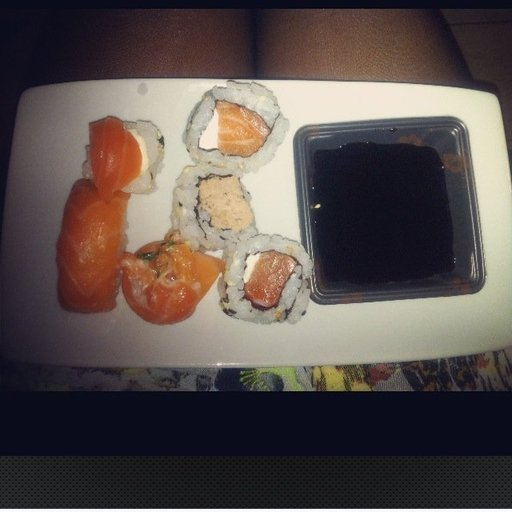

In [33]:
train_data_custom.load_image(index=0)

In [34]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 Create a function to display random images.
1. Take in a `Dataset` and a number of other parameters.
2. To prevent the display getting out of hand
3. set the random sample seed for reproducaility.
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop thorugh the random sample images and plot with matplotlib.
7. Make sure the dimesions of our images line up with matplotlib.


In [35]:
# 1. create a function to take in dataset.
def display_random_iamges(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int =10,
                          display_shape :bool = True,
                          seed:int =None):

  #2. adjust display if n is too high.
  if n > 10:
    n =10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
  #3. Set seed
  if seed:
    random.seed(seed)

  #4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)),k=n)

  #5. Setup plot
  plt.figure(figsize=(16,8))

  #6. loop through random indexes and plot
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image,targ_label = dataset[targ_sample][0],dataset[targ_sample][1]

    #7. Adjust Tensor dim for plotting
    targ_image_adjust = targ_image.permute(1,2,0)

    # plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)

    if classes:
      title = f"Class : {classes[targ_label]}"

      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"

      plt.title(title)


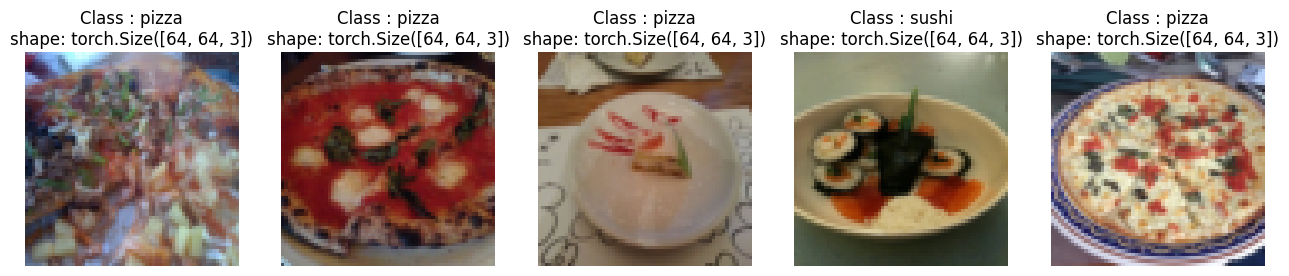

In [36]:
# Display random images from image folder.
display_random_iamges(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoaders`

In [37]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
num_workers = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=num_workers,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=num_workers,
                                    shuffle=True)


train_dataloader_custom,test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7d714b9ecee0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d714b987bb0>)

In [38]:
## Get image and label from cutom dataloader
img_custom,label_custom = next(iter(train_dataloader_custom))

# print out the shape
img_custom.shape,label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms if transform
> Data augmentation is the process of artificially adding diversity to trainning data.
> Look at the same image but from different perspectives.

Lets take a one particular type of data augmentation.

In [39]:
## Lets look at trivial augment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [40]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/2385731.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1245193.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2190404.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3837522.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/988559.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/207578.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/479711.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1434806.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3806282.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2741434.jpg')]

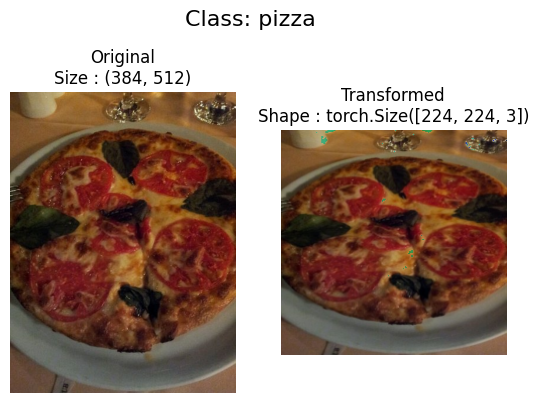

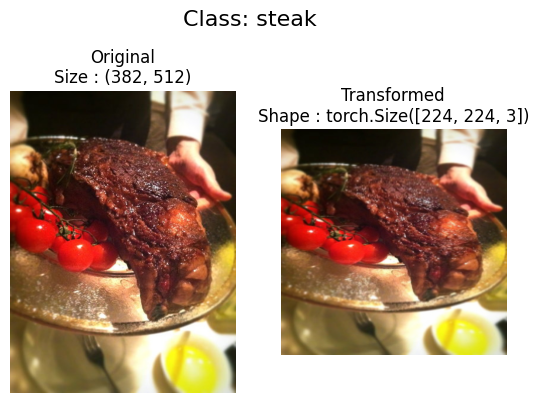

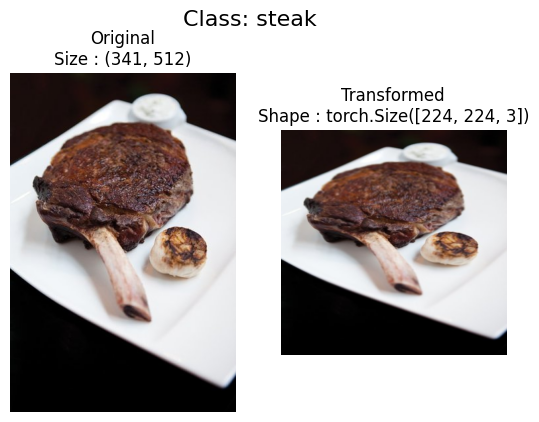

In [41]:
# Plot random trasnformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation.

Lets replicate TinyVGG from cnn explainer website.

### 7.1 Create transforms and loading data for model 0

In [42]:
# create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [43]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the database into DataLoaders.
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# create DataLoaders

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                      batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model Class.


In [44]:
class TinyVGG(nn.Module):
  '''

  '''
  def __init__(self,input_shape:int,
               hidden_units:int,
               output_shape:int) -> None:

    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )


  def forward(self,x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [45]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on asingle image

In [46]:
image_batch,label_batch = next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [47]:
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7226e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.3062e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get idea of shape going through our model.

In [48]:
# Install torchinfo
try:
  import torchinfo
except:
  ! pip install torchinfo
  import torchinfo

from torchinfo import summary

summary(model_0,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create test and train loop functions
* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [73]:
# ##Create train_step()

# def train_step(model:torch.nn.Module,
#                dataloader: torch.utils.data.DataLoader,
#                loss_fn: torch.nn.Module,
#                optimizer: torch.optim.Optimizer,
#                device:device):

#   ## Put the model in train mode
#   model.train()

#   # setup train loss and train accuracy values.
#   train_loss,train_acc =0,0

#   ## Loop through data loader data batches.
#   for batch, (X,y) in enumerate(dataloader):
#     # send data to the target device.
#     X, y = X.to(device), y.to(device)


#     # 1. forward Pass
#     y_pred = model(X)

#     # 2. Calculate the loss
#     loss = loss_fn(y_pred,y)
#     train_loss += loss.item()

#     # 3. Optimizer zero grad
#     optimizer.zero_grad()

#     # 4. Loss backward
#     loss.backward()

#     # 5. Optimizer step
#     optimizer.step()

#     # Calculate the accuracy metric
#     y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)

#   # Adjust metrics to get average loss and accuracy per batch.
#   train_loss = train_loss /len(dataloader)
#   train_acc = train_acc/ len(dataloader)

#   return train_loss,train_acc


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [74]:
# ## Create a test_step()

# def test_step(model:torch.nn.Module,
#               dataloader: torch.utils.data.DataLoader,
#               loss_fn:torch.nn.Module,device:device):
#   ## Put the model in train mode
#   model.eval()

#   ## setup test loss and test acc
#   test_loss,test_acc = 0 ,0

#   # Loop through the data loader data batches.
#   for batch,(X,y) in enumerate(dataloader):
#     # send data to target device.
#     X,y = X.to(device),y.to(device)

#     # 1. Forward pass
#     test_pred_logits = model(X)

#     # 2. Calculate and accumelate the loss.
#     loss = loss_fn(test_pred_logits, y)
#     test_loss += loss.item()

#     # Calculate and accumelate the accuracy.
#     test_pred_labels = test_pred_logits.argmax(dim=1)
#     test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

#     # Adjust metrics to get average loss and accuracy per batch
#     test_loss = test_loss / len(dataloader)
#     test_acc = test_acc / len(dataloader)
#     return test_loss, test_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [77]:
# from tqdm.auto import tqdm

# # 1. create a train function
# def train(model: torch.nn.Module,
#           train_dataloader : torch.utils.data.DataLoader,
#           test_dataloader : torch.utils.data.DataLoader,
#           optimizer: torch.optim.Optimizer,
#           loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
#           epochs: int =5):

#   # Create empty list dictionary
#   results = {
#       "train_loss":[],
#       "train_acc":[],
#       "test_loss":[],
#       "test_acc":[]
#   }

#   # 3. Loop through trainning and testing steps for number of epochs.
#   for epoch in tqdm(range(epochs)):
#     train_loss,train_acc = train_step(model=model,
#                                       dataloader=train_dataloader,
#                                       loss_fn = loss_fn,
#                                       optimizer=optimizer,
#                                       device=device)

#     test_loss,test_acc = test_step(model=model,
#                                    dataloader=test_dataloader,
#                                    loss_fn=loss_fn,
#                                    device=device)

#     # 4. Print
#     print(f"Epoch : {epoch} | Train loss : {train_loss:.4f} | Test acc : {test_acc:.4f} | Test loss : {test_loss:.4f} | Test acc : {test_acc:.4f}")

#     # 5. update result dictionary
#     results['train_loss'].append(train_loss)
#     results['train_acc'].append(train_acc)
#     results['test_loss'].append(test_loss)
#     results['test_acc'].append(train_acc)


#     #
#     return results



from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and evaluate model 0

In [78]:
# # set random seed
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# # set Number of epochs
# NUM_EPOCHS = 5

# # Recreate an instance of TinyVGG
# model_0 = TinyVGG(input_shape=3,
#                   hidden_units=10,
#                   output_shape=len(train_data.classes)).to(device)

# # setup the loss function
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model_0.parameters(),
#                              lr=0.001)

# # start the timer
# from timeit import default_timer as timer
# start_time = timer()


# # Train model_0
# model_0_results = train(model=model_0,
#                         train_dataloader=train_dataloader_simple,
#                         test_dataloader=test_data_simple,
#                         optimizer=optimizer,
#                         loss_fn=loss_fn,
#                         epochs=NUM_EPOCHS)
# #
# end_time = timer()

# print(f"Total trainning time : {end_time-start_time:.3f} seconds")






# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0979 | test_acc: 0.3409
Epoch: 2 | train_loss: 1.0835 | train_acc: 0.4453 | test_loss: 1.0777 | test_acc: 0.4223
Epoch: 3 | train_loss: 1.1063 | train_acc: 0.2812 | test_loss: 1.0818 | test_acc: 0.3826
Epoch: 4 | train_loss: 1.0755 | train_acc: 0.4766 | test_loss: 1.0780 | test_acc: 0.5047
Epoch: 5 | train_loss: 1.0663 | train_acc: 0.4023 | test_loss: 1.0518 | test_acc: 0.5038
Total training time: 6.178 seconds
